# Anomaly detection on time series

Here we take a look at the PCA-preprocessed and Mahalanobis-based anomaly detection technique on the example of the time series.

We use the dataset from https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/. 

***Data description:***
Four bearings were installed on a shaft. The rotation speed was kept constant at 2000 RPM by an AC motor coupled to the shaft via rub belts. A radial load of 6000 lbs is applied onto the shaft and bearing by a spring mechanism. All failures occurred after exceeding designed life time of the bearing which is more than 100 million revolutions. At the end of the test-to-failure experiment, outer race failure occurred in **bearing 1**.

In [120]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

Import data from the 2nd Gear failure test as data frame

In [121]:
data_dir = 'data/2nd_test'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    #print(filename)
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)

merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
print("Done")

Done


we transform the index to datetime format (using the following convention `pd.to_datetime`), and then sort the data by index in chronological order before saving the merged dataset as a .csv file

In [122]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


So now we are done formatting the data!

***Train/test procedure:*** perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions), and test on the remaining parts of the dataset leading up to the bearing failure

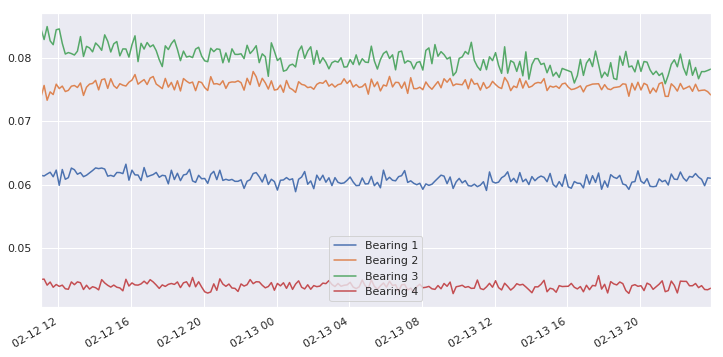

In [123]:
dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = merged_data['2004-02-13 23:52:39':]
dataset_train.plot(figsize = (12,6))

Normalize data: use preprocessing tools from Scikit-learn to scale the input variables of the model. The “MinMaxScaler” simply re-scales the data to be in the range [0,1].

In [124]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
# Random shuffle training data: return a random sample of items from an axis of object.
# Use random_state for reproducibility. Frac is franction of the data: for 1 ~ every first sample (0.5 ~ every second).
# If Fraction is >1, then replacement should be set to true
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

### PCA preprocessing for anomaly detection:

As dealing with high dimensional sensor data is often challenging, there are several techniques to reduce the number of variables (dimensionality reduction). One of the main techniques is principal component analysis (PCA).

As an initial attempt, let us compress the sensor readings down to the two main principal components.

In [125]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

Given a test sample, we compute the Mahalanobis distance to the “normal” class, and classifies the test point as an “anomaly” if the distance is above a certain threshold. 

For that we would use the inverse of the covariance matrix. It can be computed as folows, however, the inverse of the covariance matrix does not exist if it's i.e. **singular**. 

Let's take a look at the examples below:

In [145]:
# example of the singular matrix
matrix = np.array([[1, 2, 3], [2, 4, 6], [3, 6, 9]])
covariance_matrix = np.cov(matrix, rowvar=False)
covariance_matrix

array([[1., 2., 3.],
       [2., 4., 6.],
       [3., 6., 9.]])

In [146]:
### matrix is singular if and only if it has determinant 0
print("Determinant is ", np.linalg.det(covariance_matrix))
# inverse
try:
    inv_covariance_matrix = np.linalg.inv(covariance_matrix)
except np.linalg.LinAlgError as err:
    if 'Singular matrix' in str(err):
        print('It is a singular matrix - inverse does not exist')
# your error handling block

Determinant is  0.0
It is a singular matrix - inverse does not exist


In [128]:
matrix = np.array([[14, 2, 3], [2, 43, 6], [3, 6, 95]])
covariance_matrix = np.cov(matrix, rowvar=False)
covariance_matrix

array([[  44.33333333,  -95.5       , -159.83333333],
       [ -95.5       ,  511.        , -467.        ],
       [-159.83333333, -467.        , 2732.33333333]])

In [129]:
### matrix is singular if and only if it has determinant 0
np.linalg.det(covariance_matrix)

4.7855107106012495e-09

In [130]:
# inverse
inv_covariance_matrix = np.linalg.inv(covariance_matrix)
inv_covariance_matrix

array([[2.46187587e+14, 7.01241770e+13, 2.63865951e+13],
       [7.01241770e+13, 1.99742004e+13, 7.51596897e+12],
       [2.63865951e+13, 7.51596897e+12, 2.82813772e+12]])

In [131]:
# pseudoinverse
inv_covariance_matrix = np.linalg.pinv(covariance_matrix)
inv_covariance_matrix

array([[ 0.00018206, -0.00059163, -0.00012637],
       [-0.00059163,  0.00196739,  0.00029142],
       [-0.00012637,  0.00029142,  0.00040456]])

If matrix is **singular**, then it's not **invertible** (it's inverse simply does not exist). Same, apart from being non singular, not being positive-definite prevents from calculation.

However, the workaround with it in terms of Mahalanobis scores calculations can be usage of ***Moore-Penrose inverse*** `np.linalg.inv`. 

In [132]:
def cov_matrix(data, verbose=False):
    # compute covariance matrix
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        # try to take a look at the data with pseudoinverse
        #inv_covariance_matrix = np.linalg.pinv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [133]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    # data has shape number of samples x PCA components (2)
    print(diff.shape)
    md = []
    for i in range(len(diff)):
        # sqrt(deviation from mean[component] * inv cov */
        # / * deviation from mean[component])
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [134]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    # mean of the calculated scores (that are Mah. distances)
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [135]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [136]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [137]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [138]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [139]:
mean_distr = data_train.mean(axis=0)

In [140]:
# use same inv cov (from training set), mean train scores (computed from training set)
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

(760, 2)
(222, 2)


In [141]:
threshold

3.8120454918056756

In [142]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()


,Mob dist,Thresh,Anomaly
2004-02-13 23:52:39,1.032676,3.812045,False
2004-02-14 00:02:39,1.148163,3.812045,False
2004-02-14 00:12:39,1.509998,3.812045,False
2004-02-14 00:22:39,1.849725,3.812045,False
2004-02-14 00:32:39,0.701075,3.812045,False


In [143]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

## Anomaly with inverse

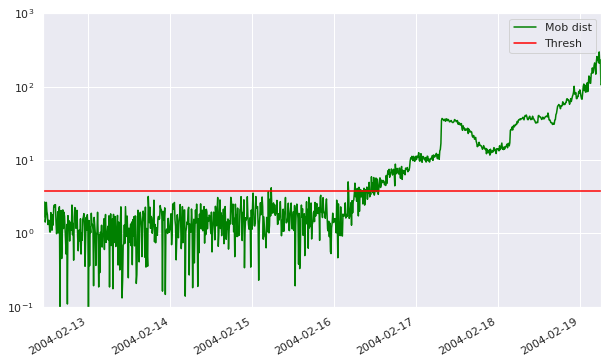

In [144]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['green','red'])

## Anomaly with pseudo inverse

#### re-run with changing np.linalg.inv to np.linalg.pinv and getting the same threshold

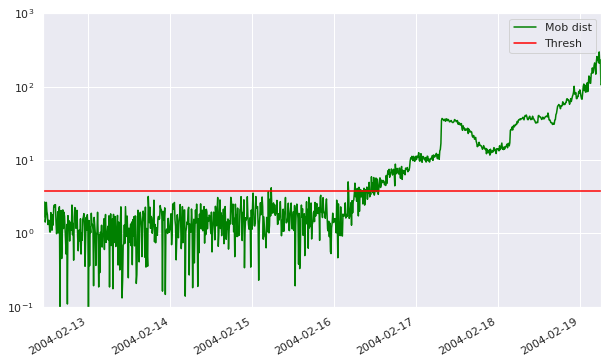

In [119]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['green','red'])

From both figures we see that the model is able to detect the anomaly *approximately 3 days* ahead of the actual bearing failure. ***We empirically proved the usage of pseudoinverse against matrix inverse.*** The question of for theoretical justification of usage of M-P inverse, as empirically it performs with the same results.

## References:

https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770